In [1]:
# ! python -m pip install stactools

In [2]:
import numpy as np
from coverage import gen_sats, gen_times, camera_model, forecast_fovs, calculate_revisits
from datetime import datetime, timezone, timedelta
import dataclasses
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import branca
import folium

from skyfield.framelib import itrs
from landsat import Instrument, Platform, Scene

! mkdir tmp

mkdir: tmp: File exists


In [3]:
start_dt = datetime.fromisoformat(Scene.start_utc)
num_days = 2

tles = gen_sats(
    # sat_nos=[Platform.norad_id] # How to best handle multiple platforms? (TLE vs. SPG4 model too)
    # sat_nos=[39084]
    sat_nos=[39084,49260]
)

inst = camera_model(
    name=Instrument.name, 
    fl=Instrument.focal_length_mm, 
    pitch=Instrument.pitch_um*1e-3, 
    h_pix=Instrument.rows, 
    v_pix=Instrument.cols, 
)

times = gen_times(
    start_yr=start_dt.year,
    start_mo=start_dt.month, 
    start_day=start_dt.day, 
    days=num_days, 
    step_min=Instrument.img_period)

xcell_size = ycell_size = .1

Satellite(s) Loaded from TLE:

[<EarthSatellite LANDSAT 8 catalog #39084 epoch 2022-06-15 18:38:09 UTC>]

[<EarthSatellite LANDSAT 9 catalog #49260 epoch 2022-06-15 11:12:37 UTC>]

Propogation time: 
 2022-07-26 00:00:00+00:00 
to 
 2022-07-27 23:59:48+00:00

In [4]:
## Batch FOV generation over N satellites - TODO: build multiple sats into config/ main script
gdfs = []
for tle in tles:
    sat = tle[0]

    fov_df = forecast_fovs(sat, times, inst)

    xyz_dist_rates = sat.at(times).frame_xyz_and_velocity(itrs)
    fov_df['x_pos'], fov_df['y_pos'], fov_df['z_pos'] = xyz_dist_rates[0].km
    fov_df['x_vel'], fov_df['y_vel'], fov_df['z_vel'] = xyz_dist_rates[1].km_per_s

    gdfs.append(fov_df)
fov_df = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs="EPSG:4326")

# fov_df.drop('datetime', axis=1).explore()

In [5]:
# fov_df.time = pd.to_datetime(fov_df.time)
fov_df["frac_days"] = fov_df.datetime.dt.dayofweek + fov_df.datetime.dt.hour/24 + fov_df.datetime.dt.minute/(24*60) + fov_df.datetime.dt.second/(24*60*60)
fov_df['time_gap'] = fov_df['frac_days'] - fov_df['frac_days'].shift(1)
# fov_df = fov_df.drop('datetime', axis=1)
fov_df

,datetime,satellite,id,time,geometry,x_pos,y_pos,z_pos,x_vel,y_vel,z_vel,frac_days,time_gap
0,2022-07-26 00:00:00+00:00,LANDSAT 8,139084,2022-07-26 00:00:00 UTC,"POLYGON ((48.69251 -82.41929, 51.23184 -80.795...",763.336641,749.121101,-7006.279929,6.705559,-3.480048,0.359449,1.000000,NaN
1,2022-07-26 00:00:22+00:00,LANDSAT 8,139084,2022-07-26 00:00:22 UTC,"POLYGON ((39.37295 -81.98888, 43.31485 -80.435...",910.518091,672.129420,-6996.479164,6.673917,-3.518846,0.531486,1.000255,0.000255
2,2022-07-26 00:00:44+00:00,LANDSAT 8,139084,2022-07-26 00:00:44 UTC,"POLYGON ((31.16828 -81.37681, 36.07937 -79.914...",1056.962644,594.306058,-6982.896512,6.638573,-3.555650,0.703240,1.000509,0.000255
3,2022-07-26 00:01:06+00:00,LANDSAT 8,139084,2022-07-26 00:01:06 UTC,"POLYGON ((24.14460 -80.61851, 29.62490 -79.255...",1202.589108,515.695254,-6965.539185,6.599550,-3.590427,0.874621,1.000764,0.000255
4,2022-07-26 00:01:28+00:00,LANDSAT 8,139084,2022-07-26 00:01:28 UTC,"POLYGON ((18.21617 -79.74632, 23.95641 -78.481...",1347.316865,436.341931,-6944.416412,6.556877,-3.623147,1.045537,1.001019,0.000255
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15705,2022-07-27 23:58:20+00:00,LANDSAT 9,149260,2022-07-27 23:58:20 UTC,"POLYGON ((163.56990 46.82996, 161.26742 47.245...",-4675.803447,1509.042909,5094.035562,-4.450427,3.438390,-5.091799,2.998843,0.000255
15706,2022-07-27 23:58:42+00:00,LANDSAT 9,149260,2022-07-27 23:58:42 UTC,"POLYGON ((163.05234 45.52560, 160.80283 45.934...",-4772.319345,1584.428542,4980.639227,-4.323363,3.414464,-5.216483,2.999097,0.000255
15707,2022-07-27 23:59:04+00:00,LANDSAT 9,149260,2022-07-27 23:59:04 UTC,"POLYGON ((162.55460 44.21930, 160.35475 44.622...",-4866.014778,1659.262932,4864.530861,-4.194034,3.388278,-5.338335,2.999352,0.000255
15708,2022-07-27 23:59:26+00:00,LANDSAT 9,149260,2022-07-27 23:59:26 UTC,"POLYGON ((162.07499 42.91118, 159.92174 43.308...",-4956.840767,1733.496440,4745.773504,-4.062518,3.359840,-5.457289,2.999606,0.000255


In [6]:
# %%timeit
# get_inst_fov(sat, times[0], inst)

In [7]:
# fov_df.loc[fov_df.z_vel < 0]['asc_dsc'] = 'dsc'
conditions = [
    fov_df['z_vel'].lt(0),
    fov_df['z_vel'].gt(0)
]

choices = ['dsc','asc']
fov_df['asc_dsc'] = np.select(conditions, choices, default='undefined')

my_column_changes = fov_df["asc_dsc"].shift() != fov_df["asc_dsc"]
change = fov_df[my_column_changes]#[:100]
change['time_gap'] = change['frac_days'].shift(-1) - change['frac_days']

# plot_df = change[change.satellite=="LANDSAT 9"][1:]
# fig, ax = plt.subplots(1, figsize=(16,6))
# ax.barh(plot_df['asc_dsc'], plot_df.time_gap, left=plot_df.frac_days) #, color=df.color)

/Users/kevinlalli/miniconda3/envs/coverage/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [8]:
## Drop ascending pass FOVs
fov_df.loc[fov_df.asc_dsc=="asc", "geometry"] = None

## Select AOI from gpd naturalearth dataset (filter by .name for country, .continent for continent)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.continent != "Antarctica"]
# world = world[world.continent != "Seven seas (open ocean)"]

## Drop any FOVs not over land area
join = fov_df.sjoin(world, how="left").dropna()
fov_df.loc[join.index, 'mode'] = "SCIENCE"
fov_df.loc[~fov_df.index.isin(join.index), 'mode'] = "STANDBY"
fov_df.loc[fov_df['mode']=="STANDBY", "geometry"] = None

/Users/kevinlalli/miniconda3/envs/coverage/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<BarContainer object of 161 artists>

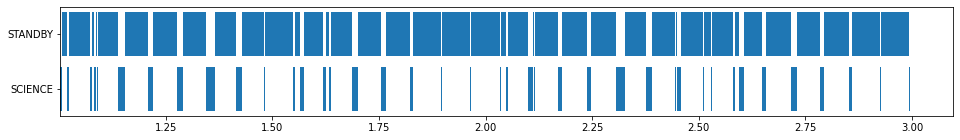

In [9]:
my_column_changes = fov_df["mode"].shift() != fov_df["mode"]

change = fov_df[my_column_changes]#[:100]

change['time_gap'] = change['frac_days'].shift(-1) - change['frac_days']
change = change[change['time_gap'] > 0]
change = change[change.satellite == "LANDSAT 9"]

fig, ax = plt.subplots(1, figsize=(16,2))
ax.barh(change['mode'], change.time_gap, left=change.frac_days) #, color=df.color)

<AxesSubplot:ylabel='Frequency'>

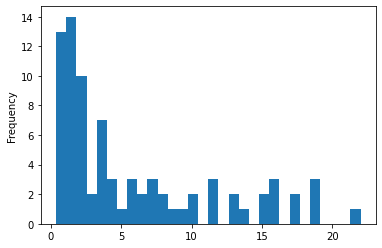

In [10]:
((change[change["mode"] == "SCIENCE"]).time_gap*24*60).plot.hist(bins=30)

In [11]:
change[change["mode"] == "SCIENCE"].time_gap.sum()/(change[change["mode"] == "STANDBY"].time_gap.sum() + change[change["mode"] == "SCIENCE"].time_gap.sum())

0.1629213483146064

In [12]:
def zero_crossing(data):
    return np.where(np.diff(np.sign(np.array(data))))[0]

def crossings_nonzero_pos2neg(data):
    pos = data > 0
    return (pos[:-1] & ~pos[1:]).nonzero()[0]

single_sat = fov_df[fov_df.satellite=="LANDSAT 8"][1:-1].reset_index(drop=True)

data = single_sat['z_pos'].values
crossings = crossings_nonzero_pos2neg(data)
single_sat.loc[crossings]
single_sat['orbit'] = 1

for crossing in crossings:
    single_sat.loc[crossing:, 'orbit'] += 1

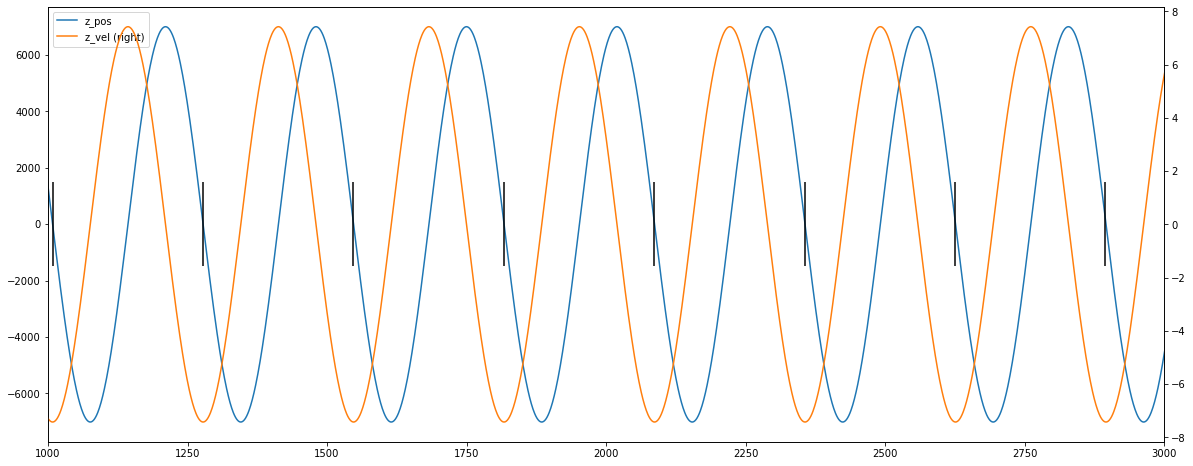

In [13]:
ax = single_sat.plot.line(y=['z_pos', 'z_vel'], xlim=[1000,3000], figsize=(20,8), subplots=False, secondary_y=['z_vel'])
ax.vlines(single_sat.loc[crossings].index, ymin=-1500, ymax=1500, color=['black'])

15.363333333333362


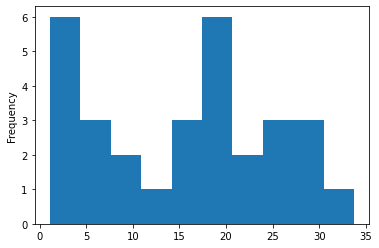

In [14]:
(single_sat[single_sat["mode"] == "SCIENCE"].groupby('orbit').time_gap.sum()*24*60).plot.hist(bins=10)

print((single_sat[single_sat["mode"] == "SCIENCE"].groupby('orbit').time_gap.sum()*24*60).mean())

In [15]:
single_sat['timedelta'] = single_sat.datetime.diff(1).shift(-1)

by_orbit = pd.DataFrame(
    {
    "SCIENCE": single_sat[single_sat['mode']=="SCIENCE"].groupby('orbit').timedelta.sum(),
    "STANDBY": single_sat[single_sat['mode']=="STANDBY"].groupby('orbit').timedelta.sum()
    }
)

by_orbit["SCIENCE_min"] = by_orbit.SCIENCE.dt.total_seconds()/60
by_orbit["STANDBY_min"] = by_orbit.STANDBY.dt.total_seconds()/60

by_orbit["DATA_LWIR_HS"] = by_orbit.SCIENCE.dt.total_seconds()*0.201
by_orbit["DATA_LWIR_HR"] = by_orbit.SCIENCE.dt.total_seconds()*0.60

In [16]:
by_orbit

,SCIENCE,STANDBY,SCIENCE_min,STANDBY_min,DATA_LWIR_HS,DATA_LWIR_HR
orbit,,,,,,
1,0 days 00:04:46,0 days 01:08:12,4.766667,68.200000,57.486,171.6
2,0 days 00:24:56,0 days 01:13:42,24.933333,73.700000,300.696,897.6
3,0 days 00:17:58,0 days 01:21:02,17.966667,81.033333,216.678,646.8
4,0 days 00:15:46,0 days 01:23:14,15.766667,83.233333,190.146,567.6
5,0 days 00:20:54,0 days 01:17:44,20.900000,77.733333,252.054,752.4
6,0 days 00:28:14,0 days 01:10:46,28.233333,70.766667,340.494,1016.4
7,0 days 00:17:58,0 days 01:21:02,17.966667,81.033333,216.678,646.8
8,0 days 00:03:18,0 days 01:35:20,3.300000,95.333333,39.798,118.8
9,0 days 00:15:02,0 days 01:23:58,15.033333,83.966667,181.302,541.2


<AxesSubplot:ylabel='Frequency'>

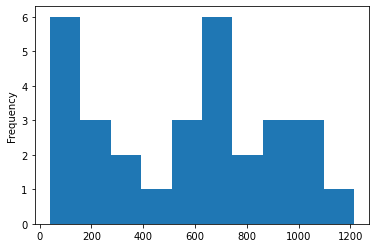

In [17]:
by_orbit.DATA_LWIR_HR.plot.hist(bins=10)

In [18]:
by_orbit.DATA_LWIR_HR.sum()

16592.4

In [19]:
0.16*24*60*60*0.6

8294.399999999998